In [1]:
from ibmm import EyeClassifier
# from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

from parser_utils import read_periph_recording, parse_new_dreyevr_rec, GetGazeDeviationFromHead
from pathlib import Path
from tqdm import tqdm
import pickle as pkl

In [2]:
from scipy.spatial.transform import Rotation as R

In [3]:
%matplotlib ipympl

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append(".\\dreyevr_parser")

In [6]:
from dreyevr_parser.parser import parse_file
from typing import Dict, List, Any
from utils import (
    check_for_periph_data,
    convert_to_df,
    split_along_subgroup,
    get_good_idxs,
)
from visualizer import plot_versus

In [87]:
# path_to_recording = "C://carla//carla.periph//OtherExptRecordings/NDT_ben1.txt"
# path_to_recording = "C://carla//carla.periph//OtherExptRecordings/NDT_aj2.txt"
# path_to_recording = "C://carla//carla.periph//OtherExptRecordings/NDT_testAngleFC.txt"
path_to_recording = "C://carla//carla.periph//OtherExptRecordings/NDT_Maggie_16_25_70.txt"
# path_to_recording = "C://carla//carla.periph//OtherExptRecordings/NDT_testPK_5_12_1.txt"
# path_to_recording = "C://carla//carla.periph//OtherExptRecordings/NDT_testMichelle_5_17_10_50.txt"
# path_to_recording = "C://carla//carla.periph//OtherExptRecordings/NDT_testThomas_5_16_10_70.txt"
# path_to_recording = "C://carla//carla.periph//OtherExptRecordings/NDT_testAbhijat_5_17_10_35.txt"

recording_name = Path(path_to_recording).stem
recdf_pklname = Path("temp_data").joinpath(recording_name+".pkl")

# try:
#     og_df = pd.read_pickle(recdf_pklname)
# except FileNotFoundError:
#     og_df = read_periph_recording(path_to_recording)
#     og_df.to_pickle(recdf_pklname)
# og_df = og_df.convert_dtypes()

In [88]:
data: Dict[str, np.ndarray or dict] = parse_file(path_to_recording, debug=True)

Loaded data from cache\NDT_Maggie_16_25_70.pkl


In [89]:
"""append/generate periph data if available"""
# check for periph data
PeriphData = check_for_periph_data(data)
if PeriphData is not None:
    data["PeriphData"] = PeriphData

"""convert to pandas df"""
# need to split along groups so all data lengths are the same
data_groups = split_along_subgroup(data, ["CustomActor"])
data_groups_df: List[pd.DataFrame] = [convert_to_df(x) for x in data_groups]
df_new = data_groups_df[-1]

gathered periph data in 0.026s
created DReyeVR df in 0.026s
created DReyeVR df in 0.088s


In [90]:
CAs_present = data_groups_df[0].CustomActor_Name.unique() # 'PeriphCross', 'PeriphTarget'
assert ('PeriphCross' in CAs_present and 'PeriphTarget' in CAs_present)

In [91]:
CA_df = data_groups_df[0]
CA_df.rename(columns={"CustomActor_t": "TimestampCarla"}, inplace=True)
og_df = data_groups_df[1]

## Data Playground and Sanity checks

In [92]:
# find the indices where lights came on and went off
lighton_rows = og_df["LightOn"].diff().fillna(0)==1
lightoff_rows = og_df["LightOn"].diff().fillna(0)==-1
og_df[lighton_rows].head()
lighton_idcs = og_df[lighton_rows].index
num_targets_spawned = sum(lighton_rows)
# find the indices where the button was pressed
buttonPress_rows = og_df["ButtonPressed"].diff().fillna(0)==1
buttonRelease_rows = og_df["ButtonPressed"].diff().fillna(0)==-1
num_button_presses = sum(buttonPress_rows)
print("{} targets spawned".format(num_targets_spawned))
print("{} responses recorded".format(num_button_presses)) # may or may not be all accurate responses that correspond to targets?

46 targets spawned
46 responses recorded


In [93]:
rightPress_rows = og_df["TurnSignalRight"].diff().fillna(0)==1
rightRelease_rows = og_df["TurnSignalRight"].diff().fillna(0)==-1

leftPress_rows = og_df["TurnSignalLeft"].diff().fillna(0)==1
leftRelease_rows = og_df["TurnSignalLeft"].diff().fillna(0)==-1

In [94]:
df2 = og_df.copy()
df2['gaze_x'] = og_df.GazeDir_COMBINED.apply(lambda x: x[0])
df2['gaze_y'] = og_df.GazeDir_COMBINED.apply(lambda x: x[1])
df2['gaze_z'] = og_df.GazeDir_COMBINED.apply(lambda x: x[2])

gaze_pitches = np.arctan2(df2.gaze_z, df2.gaze_x)*180/np.pi
gaze_yaws = np.arctan2(df2.gaze_y, df2.gaze_x)*180/np.pi

low_conf_gazeidcs = (gaze_pitches*gaze_yaws == 0)
gaze_pitches = gaze_pitches[~low_conf_gazeidcs]
gaze_yaws = gaze_yaws[~low_conf_gazeidcs]


print(np.min(gaze_pitches),np.max(gaze_pitches))
print(np.min(gaze_yaws),np.max(gaze_yaws))

-21.630886836517927 19.41457852439166
-20.88072243357325 21.1259628679511


C:\Users\Abhijat\AppData\Local\Temp/ipykernel_43340/979472413.py:15: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


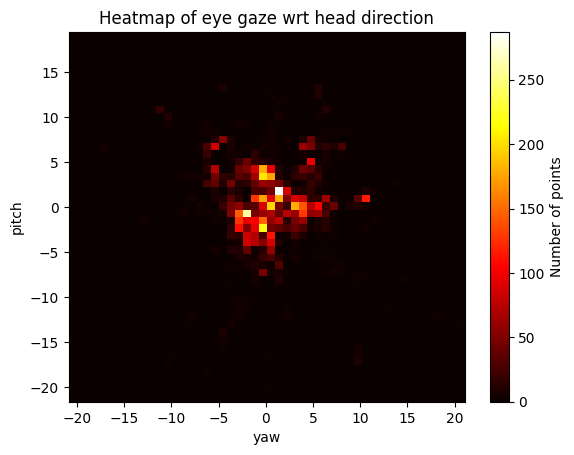

In [95]:
#gaze_pitches = gaze_pitches[1000:7000]
#gaze_yaws = gaze_yaws[6000:7000]

# Generate heat map of eye gaze wrt head pos
fig = plt.figure()
plt.hist2d(gaze_yaws, gaze_pitches,
           bins=50, cmap='hot')
cb = plt.colorbar()
cb.set_label('Number of points')
plt.title('Heatmap of eye gaze wrt head direction')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.xlabel('yaw')
plt.ylabel('pitch')
plt.show()
fig

## Hits and Misses calculation

In [96]:
# for every light appearance
# find the nearest button press, before the next target appearance
max_reaction_time_allowed = 1 #seconds
time_offsets = []
hits_and_misses = []

for idx_num, lighton_idx in tqdm(enumerate(lighton_idcs)):
    offset = 0
    target_tuple = (og_df.loc[lighton_idx], False)
    while lighton_idx+offset < max(og_df.index):
        time_offset = og_df.loc[lighton_idx+offset, "TimeElapsed"] - og_df.loc[lighton_idx, "TimeElapsed"]   
        
        if (og_df.loc[lighton_idx+offset, "ButtonPressed"] == 1):
            # print( "{0:1.2f}s".format(time_offset))
            # found a response
            # now check if the paddle side matched the PT appearance side wrt the FC
            TimestampCarla_lighton = og_df.loc[lighton_idx, "TimestampCarla"]
            CA_row_lighton = CA_df[CA_df["TimestampCarla"] == TimestampCarla_lighton]
            FC_row_lighton = CA_row_lighton[CA_row_lighton.CustomActor_Name == "PeriphCross"]
            PT_row_lighton = CA_row_lighton[CA_row_lighton.CustomActor_Name == "PeriphTarget"]
            
            # is the 'y' of the PT less than that of the FC? (left spawn)        
            # TODO : if we want to add a margin of error for stuff that is close, we can do it?
            if PT_row_lighton.CustomActor_Location.squeeze()[1] < FC_row_lighton.CustomActor_Location.squeeze()[1]:
                if og_df.loc[lighton_idx+offset, "TurnSignalLeft"] == 1:
                    time_offsets += [time_offset]
                    target_tuple = (og_df.loc[lighton_idx], og_df.loc[lighton_idx+offset])
                    # print("Hit @ #{}, {}".format(idx_num, lighton_idx))
                    break
                elif og_df.loc[lighton_idx+offset, "TurnSignalRight"] == 1:
                    # this is the wrong side response
                    print("Wrong sided response @ {}".format(lighton_idx))
                    break
            else:
                if og_df.loc[lighton_idx+offset, "TurnSignalRight"] == 1:
                    time_offsets += [time_offset]
                    target_tuple = (og_df.loc[lighton_idx], og_df.loc[lighton_idx+offset])
                    # print("Hit @ #{}, {}".format(idx_num, lighton_idx))
                    break
                elif og_df.loc[lighton_idx+offset, "TurnSignalLeft"] == 1:
                    # this is the wrong side response
                    print("Wrong sided response @ {}".format(lighton_idx))
                    break
            
        else:
            if time_offset > max_reaction_time_allowed:
                print("Miss @ #{}, {}".format(idx_num+1, lighton_idx))
                break
            offset += 1
            # print(offset)
    hits_and_misses += [target_tuple]
    
print("{}/{} hits with a {}s average reaction time".format(len(time_offsets), len(lighton_idcs), sum(time_offsets)/len(time_offsets)))

46it [00:00, 121.69it/s]

46/46 hits with a 0.577312608695651s average reaction time


## Prelim analysis

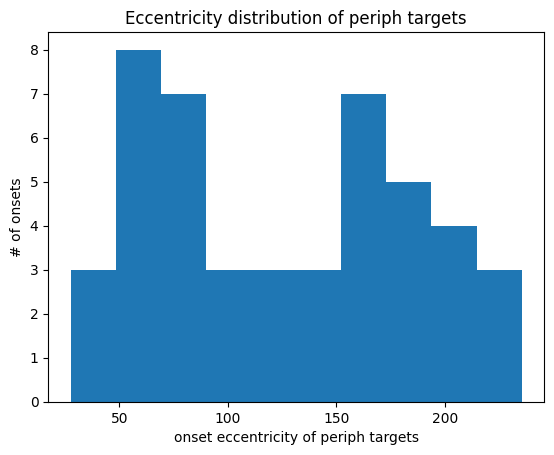

In [97]:
# Preliminary analysis
fig, ax = plt.subplots()

ecc = np.zeros(len(hits_and_misses))


for ctr, target_tuple in enumerate(hits_and_misses):
    target_response = True
    if target_tuple[1] is False:
        # miss
        target_response = False
        pass
    else:
        pass

    ecc[ctr] = np.linalg.norm([target_tuple[0].gaze2target_yaw*180/np.pi, target_tuple[0].gaze2target_pitch*180/np.pi])

ax.hist(ecc)
ax.set_title("Eccentricity distribution of periph targets")
ax.set_xlabel("onset eccentricity of periph targets")
ax.set_ylabel("# of onsets")

fig

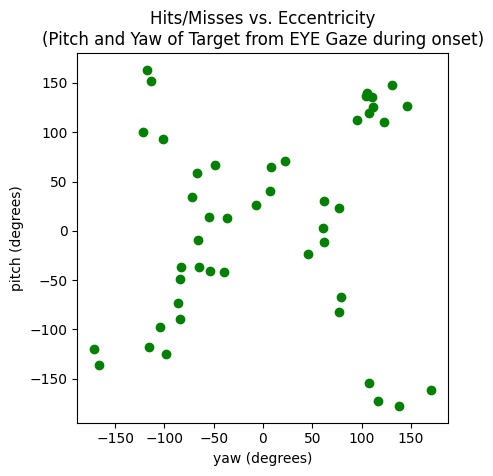

In [98]:
# Preliminary analysis
fig, ax = plt.subplots()

# plots of hits misses vs ecc
for target_tuple in hits_and_misses:
    target_response = True
    if target_tuple[1] is False:
        # miss
        target_response = False
        pass
    else:
        # hits
        pass
        # print(target_tuple[1].ButtonPressed)
    ax.scatter(target_tuple[0].gaze2target_yaw*180/np.pi,
               target_tuple[0].gaze2target_pitch*180/np.pi,
               c='g' if target_response else 'r')
    ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from EYE Gaze during onset)")
    
    # ax.scatter(target_tuple[0].head2target_yaw*180/np.pi, target_tuple[0].head2target_pitch*180/np.pi, c='g' if target_response else 'r')
    # ax.set_title("Hits/Misses vs. Eccentricity\n(Pitch and Yaw of Target from HEAD Gaze during onset)")
    
    ax.set_xlabel("yaw (degrees)")
    ax.set_ylabel("pitch (degrees)")
    # ax.set_xlim(-60, 60)
    # ax.set_ylim(-40, 60)
    ax.set_aspect('equal')
    # ax.show()
fig

## Gaze event detection (gaze vector/gaze+head only)


In [263]:
from ibmm import EyeClassifier
from ibmm_online import EyeClassifierOnline

In [264]:
gazeORgazeHead = "gazeHead"
dist_method="vector" # vector or euclid

In [265]:
df2 = og_df.copy()
if gazeORgazeHead == "gaze":
    df2['Lgaze_x'] = og_df.GazeDir_LEFT.apply(lambda x: x[0])
    df2['Lgaze_y'] = og_df.GazeDir_LEFT.apply(lambda x: x[1])
    df2['Lgaze_z'] = og_df.GazeDir_LEFT.apply(lambda x: x[2])

    df2['Rgaze_x'] = og_df.GazeDir_RIGHT.apply(lambda x: x[0])
    df2['Rgaze_y'] = og_df.GazeDir_RIGHT.apply(lambda x: x[1])
    df2['Rgaze_z'] = og_df.GazeDir_RIGHT.apply(lambda x: x[2])


    LgazeRaySplitDF = pd.DataFrame(df2[['Lgaze_x', 'Lgaze_y', 'Lgaze_z']])
    LgazeRaySplitDF.rename(columns={'Lgaze_x': 'x', 'Lgaze_y': 'y', 'Lgaze_z': 'z'}, inplace=True)
    LgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
    LgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_LEFT"].astype(bool) # remove all gazes where an eye was closed

    RgazeRaySplitDF = pd.DataFrame(df2[['Rgaze_x', 'Rgaze_y', 'Rgaze_z']])
    RgazeRaySplitDF.rename(columns={'Rgaze_x': 'x', 'Rgaze_y': 'y', 'Rgaze_z': 'z'}, inplace=True)
    RgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
    RgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_RIGHT"].astype(bool) # remove all gazes where an eye was closed
    
    velL = EyeClassifier.preprocess(LgazeRaySplitDF, dist_method=dist_method)
    velL.velocity = velL.velocity.astype(float)
    velR = EyeClassifier.preprocess(RgazeRaySplitDF, dist_method=dist_method)
    velR.velocity = velR.velocity.astype(float)
    model = EyeClassifier()
    model.fit(eyes=(velL, velR))
    labels, indiv_labels = model.predict(eyes=(velL, velR))
    labels_unique = labels[1::2]
    
elif gazeORgazeHead == "gazeHead":
    # add approx head compensation
    df2['Cgaze_x'] = og_df.GazeDir_COMBINED.apply(lambda x: x[0])
    df2['Cgaze_y'] = og_df.GazeDir_COMBINED.apply(lambda x: x[1])
    df2['Cgaze_z'] = og_df.GazeDir_COMBINED.apply(lambda x: x[2])

    # gaze+head values
    gaze_pitches, gaze_yaws = GetGazeDeviationFromHead(df2.Cgaze_x, df2.Cgaze_y, df2.Cgaze_z)
    head_rots = df2.CameraRot.values
    head_pitches =   df2.CameraRot.apply(lambda x: x[0])
    head_yaws = df2.CameraRot.apply(lambda x: x[2])
    gaze_head_pitches = gaze_pitches + head_pitches
    gaze_head_yaws = gaze_yaws + head_yaws       

    # Create the new pd
    gazeHeadDF = pd.DataFrame(df2[['TimeElapsed']])
    gazeHeadDF = gazeHeadDF.rename(columns={'TimeElapsed':'timestamp'})
    gazeHeadDF['confidence'] = (df2.EyeOpennessValid_LEFT*df2.EyeOpennessValid_RIGHT).astype(bool)
    gazeHeadDF['x'] = gaze_head_pitches
    gazeHeadDF['y'] = gaze_head_yaws
    gazeHeadDF['z'] = np.zeros(len(gaze_head_pitches))
    
    vel_w = EyeClassifier.preprocess(gazeHeadDF, dist_method=dist_method)
    model = EyeClassifier()
    model.fit(world=vel_w)
    # raw_vel = vel_w[np.logical_not(vel_w.velocity.isna())].velocity.values
    # raw_vel[raw_vel > raw_vel.mean() + 3 * raw_vel.std()]
    # print("Velocity Means: ",model.world_model.means_)
    
    labels, indiv_labels = model.predict(world=vel_w)
    labels_unique = labels

In [266]:
# 0- fix, 1- sac, -1 -> noise
labels_unique.index = np.arange(1, len(labels_unique) + 1) # start index from 1 instead of 0
labels_np = labels_unique.to_numpy()
print("labels_np.shape: ", labels_np.shape)
# add the labels to the original df:
recdf_with_labels = df2.join(labels_unique["label"])

labels_np.shape:  (9932, 5)


In [267]:
print("Num fixation total pts: ", np.sum(labels_np[:,2]))
print("Num saccades total pts: ", np.sum(labels_np[:,3]))
print("Num noise total pts: ", np.sum(labels_np[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_np[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_np[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_np[:, 4]) == 1))
print("Num targets spawned: ", num_targets_spawned)

Num fixation total pts:  8817.0
Num saccades total pts:  925.0
Num noise total pts:  190.0

Num fixations:  451
Num saccades:  453
Num noise:  58
Num targets spawned:  47


## OFD vs FC movement analysis

In [19]:
# find all fixation cross movement points
FC_df = CA_df[CA_df.CustomActor_Name == "PeriphCross"].copy()
FC_df.loc[:, "CustomActor_Location"] = FC_df.loc[:, "CustomActor_Location"].apply(np.asarray) 
FC_move_true = (FC_df.CustomActor_Location.diff().apply(np.sum) != 0.0)
FC_move_idcs = (FC_move_true == True)
num_FC_moves= FC_move_idcs.sum()

In [20]:
FC_df[FC_move_true]

,TimestampCarla,CustomActor_Name,CustomActor_Location,CustomActor_Rotation,CustomActor_Scale3D,CustomActor_MeshPath,CustomActor_MaterialMetallic,CustomActor_MaterialSpecular,CustomActor_MaterialRoughness,CustomActor_MaterialAnisotropy,CustomActor_MaterialOpacity,CustomActor_MaterialBaseColor,CustomActor_MaterialEmissive,CustomActor_MaterialPath
0,8988,PeriphCross,"[-26700.0, 20500.0, -6000.0]","[0.0, -179.999969, 0.0]","[0.1, 0.1, 0.1]",StaticMesh'/Game/DReyeVR/Custom/Shapes/SM_Cros...,1.0,0.0,1.0,1.0,1.0,"[0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0]",Material'/Game/DReyeVR/Custom/OpaqueParamMater...


In [21]:
TC = FC_df.loc[FC_df[FC_move_true].index[0], "TimestampCarla"]
FC_move_idx = og_df[og_df.TimestampCarla==TC].index
camera_rot = R.from_euler('xyz', # UE4 rotators are pitch roll yaw
                          np.array(og_df.loc[FC_move_idx, "CameraRotAbs"].squeeze()), degrees=True)
# at numFCmoves = 0
CrossVector = camera_rot.apply([1,0,0]);
FixCrossLoc = og_df.loc[FC_move_idx, "CameraLocAbs"].squeeze() + CrossVector * 3 * 100;
print(np.allclose(FixCrossLoc, FC_df.loc[FC_move_idx, "CustomActor_Location"].squeeze(), atol=0.3))
print(FixCrossLoc)
print(FC_df.loc[FC_move_idx, "CustomActor_Location"])

True
[-26700.  20500.  -6000.]
0    [-26700.0, 20500.0, -6000.0]
Name: CustomActor_Location, dtype: object


In [22]:
# find all fixation indexrts
# for each, find when the gaze comes some threshold nearby the FC location
for idx in FC_df[FC_move_true].index:
    TC = FC_df.loc[idx, "TimestampCarla"]
    FC_move_idx = og_df[og_df.TimestampCarla==TC].index
    FC_new_loc = FC_df.loc[idx, "CustomActor_Location"]
    # print("\nidx: ", idx)
    print("Time elapsed: ", og_df.loc[FC_move_idx, "TimeElapsed"])
    ctr = 0
    while True:
              
        # FC_dir = FixCrossLoc - Gaze_origin_abs;
        # FC_dir.Normalize();
        # DotProd = FVector::DotProduct(FC_dir, Gaze_posn_rel);
        # angleGaze2FC = UKismetMathLibrary::Acos(DotProd);        
        
        # Gaze_origin_abs = CameraLoc + EgoSensor->GetData()->GetGazeOrigin(DReyeVR::Gaze::COMBINED);
        Gaze_origin_abs = np.array(og_df.loc[FC_move_idx+ctr, "GazeOrigin_COMBINED"].squeeze()) \
                            + np.array(og_df.loc[FC_move_idx+ctr, "CameraLocAbs"].squeeze())
        # Gaze_dir_rel = EgoSensor->GetData()->GetGazeDir(DReyeVR::Gaze::COMBINED);
        Gaze_dir_rel = np.array(og_df.loc[FC_move_idx+ctr, "GazeDir_COMBINED"].squeeze()) #[None,:]
        
        # Gaze_posn_rel = CameraRot.RotateVector(Gaze_dir_rel);
        # Gaze_posn_abs = Gaze_origin_abs + Gaze_posn_rel;
        # Need to rotate by CameraRotAbs to get GazeOrigin2FC_vec vector in the camera(head) frame
        camera_rot = R.from_euler('xyz', np.array(og_df.loc[FC_move_idx+ctr, "CameraRotAbs"].squeeze()), degrees=True)
        Gaze_posn_rel = camera_rot.apply(Gaze_dir_rel)
        
        FC_dir = FC_new_loc - Gaze_origin_abs
        dot_prod = np.dot(FC_dir/np.linalg.norm(FC_dir), Gaze_posn_rel/np.linalg.norm(Gaze_posn_rel))
        angle = np.arccos(dot_prod)
        # print(angle)        

        # pitch, yaw = get_angles(Gaze_vec, GazeOrigin2FC_vec)
        
        if ctr % 5 == 0:            
            # print(GazeOrigin2FC_vec)
            print(ctr, angle)
            # print(pitch, yaw)
        if ctr == 50:
            break
        ctr += 1        
    # break

Time elapsed:  0    0.0
Name: TimeElapsed, dtype: float64
0 0.1970819525514399
5 0.19712448584246128
10 0.19708195255144104
15 0.1975218071843478
20 0.19754427065735214
25 0.19750183728146345
30 0.19722202391350177
35 0.1968616178741935
40 0.19735199180041343
45 0.1975218071843478
50 0.19748436178507928


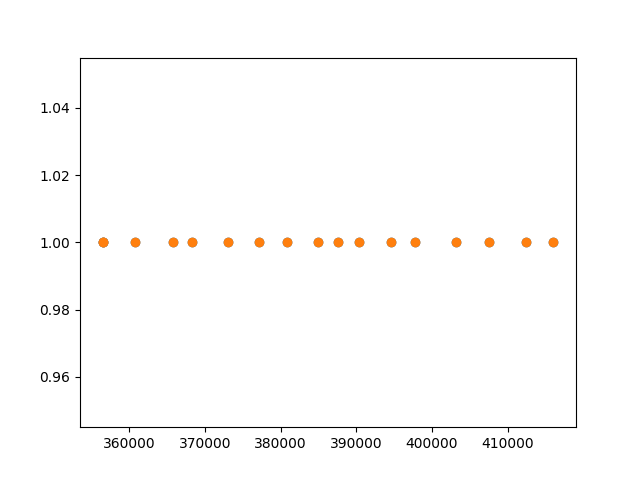

In [30]:
plt.figure()
plt.scatter(FC_df[FC_move_true].TimestampCarla, np.ones(17,))
plt.scatter(FC_df[FC_move_true].TimestampCarla, np.ones(17,))
plt.show()

## OFD analysis

In [60]:
# need a data format that stores:
# all the data from hits and misses
# what trial/recording file it corresponds to: recording_name -- this is also stored in the pkl name
# 

46/47 valid targets
41 fixation onsets, 5 sacc, 0 noise


Text(0.5, 1.0, 'Hits/Misses on Gaze Eccentricity vs. OFD')

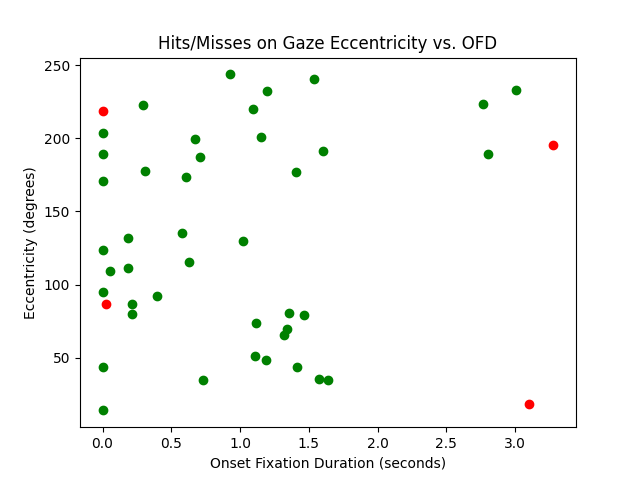

In [268]:
# target tuples, go back and find labels
saccade_onsets = 0
fixation_onsets = 0
noise_onsets = 0
fig, ax = plt.subplots()
graph_tuples = []

for target_tuple in hits_and_misses:
    # for either hit or miss, go back and find the ofd
    # check if you're in a fixation rn
    if target_tuple[0].GazeValid_COMBINED==0: # check gaze validity 
        continue
    target_locindf = target_tuple[0].name
    onset_gaze_event = recdf_with_labels.loc[target_locindf].label  
    OFD = 0
    pitch = recdf_with_labels.loc[target_locindf].gaze2target_pitch
           # + recdf_with_labels.loc[target_locindf].head2target_pitch
    yaw = recdf_with_labels.loc[target_locindf].gaze2target_yaw 
           # + recdf_with_labels.loc[target_locindf].head2target_yaw
    
    if onset_gaze_event == 0:
        fixation_onsets += 1
        # go back and look at when this current fixation ends
        # labels going back from current gaze
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        np.diff(labels_upto_curr)
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        label_diff = np.diff(labels_upto_curr)!=0
        first_fixation_idx = target_locindf - np.argmax(label_diff)
        OFD = recdf_with_labels.loc[target_locindf].TimeElapsed -\
                recdf_with_labels.loc[first_fixation_idx].TimeElapsed
        
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OFD, eccentricity, target_tuple[1] is False, pitch, yaw)
    elif onset_gaze_event == 1:
        saccade_onsets += 1
        OFD = 0        
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OFD, eccentricity, target_tuple[1] is False, pitch, yaw)
    else:
        noise_onsets += 1
    # print(target_locindf, OFD)
print("{}/{} valid targets".format(
        fixation_onsets+saccade_onsets+noise_onsets,
        len(hits_and_misses)))
print("{} fixation onsets, {} sacc, {} noise".format(fixation_onsets, saccade_onsets, noise_onsets))

#plt.xlim(0, )
# ax.set_ylim(-1, 60)
ax.set_xlabel("Onset Fixation Duration (seconds)")
ax.set_ylabel("Eccentricity (degrees)")
ax.set_title("Hits/Misses on Gaze Eccentricity vs. OFD")

In [17]:
# temp hack for henny meeting: save graph tuples
graph_data_filname = Path("temp_data").joinpath(recording_name+"_OFDvEcc.pkl")
with open(graph_data_filname, 'wb') as f:
    pkl.dump(graph_tuples, f)

# Saccade amplitude analysis


12/12 valid targets
11 fixation onsets, 1 sacc, 0 noise


Text(0.5, 1.0, 'Hits/Misses on Gaze Eccentricity vs. OFD')

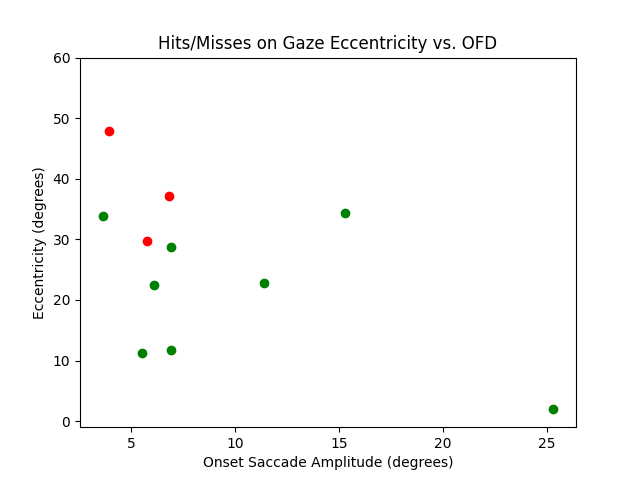

In [80]:
# target tuples, go back and find labels
saccade_onsets = 0
fixation_onsets = 0
noise_onsets = 0
fig, ax = plt.subplots()
graph_tuples = []

for target_tuple in hits_and_misses:
    # for either hit or miss, go back and find the ofd
    # check if you're in a fixation rn
    if target_tuple[0].GazeValid_COMBINED==0: # check gaze validity 
        continue
    target_locindf = target_tuple[0].name
    onset_gaze_event = recdf_with_labels.loc[target_locindf].label  
    OSA = 0
    pitch = recdf_with_labels.loc[target_locindf].gaze2target_pitch
           # + recdf_with_labels.loc[target_locindf].head2target_pitch
    yaw = recdf_with_labels.loc[target_locindf].gaze2target_yaw 
           # + recdf_with_labels.loc[target_locindf].head2target_yaw
    
    if onset_gaze_event == 0:
        fixation_onsets += 1
        # go back and look at when this current fixation ends
        # labels going back from current gaze
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        label_diff = np.diff(labels_upto_curr)!=0
        first_fixation_idx = target_locindf - np.argmax(label_diff) # first fixation of this idx
        
        labels_upto_curr = recdf_with_labels.loc[target_locindf::-1].label 
        rev_fix_idcs = np.where(labels_upto_curr==0)
        last_nonfix_offset = np.where(np.diff(rev_fix_idcs)>1)[1][0]# where is the break in the fixation
        last_fixend_idx = rev_fix_idcs[0][last_nonfix_offset+1]
        # onset saccade idx
        OSA = np.linalg.norm(recdf_with_labels.loc[target_locindf].GazeDir_COMBINED - recdf_with_labels.loc[last_fixend_idx].GazeDir_COMBINED)*180/np.pi
        
                
        eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
                                      recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        ax.scatter(OSA, eccentricity, c='r' if target_tuple[1] is False else 'g')
        graph_tuples += (OSA, eccentricity, target_tuple[1] is False, pitch, yaw)
        
    elif onset_gaze_event == 1:
        saccade_onsets += 1
        # OFD = 0        
        # eccentricity = np.linalg.norm([recdf_with_labels.loc[target_locindf].gaze2target_pitch,
        #                               recdf_with_labels.loc[target_locindf].gaze2target_yaw])*180/np.pi
        # ax.scatter(OFD, eccentricity, c='r' if target_tuple[1] is False else 'g')
        # graph_tuples += (OFD, eccentricity, target_tuple[1] is False, pitch, yaw)
    else:
        noise_onsets += 1
    # print(target_locindf, OFD)
print("{}/{} valid targets".format(
        fixation_onsets+saccade_onsets+noise_onsets,
        len(hits_and_misses)))
print("{} fixation onsets, {} sacc, {} noise".format(fixation_onsets, saccade_onsets, noise_onsets))

#plt.xlim(0, )
ax.set_ylim(-1, 60)
ax.set_xlabel("Onset Saccade Amplitude (degrees)")
ax.set_ylabel("Eccentricity (degrees)")
ax.set_title("Hits/Misses on Gaze Eccentricity vs. OFD")

# OFD analysis with Eye gaze + Head compensation

In [192]:
df2 = og_df.copy()
df2['Lgaze_x'] = og_df.GazeDir_LEFT.apply(lambda x: x[0])
df2['Lgaze_y'] = og_df.GazeDir_LEFT.apply(lambda x: x[1])
df2['Lgaze_z'] = og_df.GazeDir_LEFT.apply(lambda x: x[2])

df2['Rgaze_x'] = og_df.GazeDir_RIGHT.apply(lambda x: x[0])
df2['Rgaze_y'] = og_df.GazeDir_RIGHT.apply(lambda x: x[1])
df2['Rgaze_z'] = og_df.GazeDir_RIGHT.apply(lambda x: x[2])

df2['Cgaze_x'] = og_df.GazeDir_COMBINED.apply(lambda x: x[0])
df2['Cgaze_y'] = og_df.GazeDir_COMBINED.apply(lambda x: x[1])
df2['Cgaze_z'] = og_df.GazeDir_COMBINED.apply(lambda x: x[2])


LgazeRaySplitDF = pd.DataFrame(df2[['Lgaze_x', 'Lgaze_y', 'Lgaze_z']])
LgazeRaySplitDF.rename(columns={'Lgaze_x': 'x', 'Lgaze_y': 'y', 'Lgaze_z': 'z'}, inplace=True)
LgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
LgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_LEFT"].astype(bool) # remove all gazes where an eye was closed

RgazeRaySplitDF = pd.DataFrame(df2[['Rgaze_x', 'Rgaze_y', 'Rgaze_z']])
RgazeRaySplitDF.rename(columns={'Rgaze_x': 'x', 'Rgaze_y': 'y', 'Rgaze_z': 'z'}, inplace=True)
RgazeRaySplitDF['timestamp'] = df2["TimeElapsed"]
RgazeRaySplitDF['confidence'] = df2["EyeOpennessValid_RIGHT"].astype(bool) # remove all gazes where an eye was closed

In [193]:
velL = EyeClassifier.preprocess(LgazeRaySplitDF, dist_method='vector')
velL.velocity = velL.velocity.astype(float)
velR = EyeClassifier.preprocess(RgazeRaySplitDF, dist_method='vector')
velR.velocity = velR.velocity.astype(float)

In [148]:
# add approx head compensation
# gaze+head values
gaze_pitches, gaze_yaws = GetGazeDeviationFromHead(df2.Cgaze_x, df2.Cgaze_y, df2.Cgaze_z)

head_rots = df2.CameraRot.values
head_pitches =   df2.CameraRot.apply(lambda x: x[0])
head_yaws = df2.CameraRot.apply(lambda x: x[2])
    
gaze_head_pitches = gaze_pitches + head_pitches
gaze_head_yaws = gaze_yaws + head_yaws       

In [200]:
# Create the new pd

gazeHeadDF = pd.DataFrame(df2[['TimeElapsed']])
gazeHeadDF = gazeHeadDF.rename(columns={'TimeElapsed':'timestamp'})
gazeHeadDF['confidence'] = (df2.EyeOpennessValid_LEFT*df2.EyeOpennessValid_RIGHT).astype(bool)
gazeHeadDF['x'] = gaze_head_pitches
gazeHeadDF['y'] = gaze_head_yaws
gazeHeadDF['z'] = np.zeros(len(gaze_head_pitches))

In [212]:
vel_w = EyeClassifier.preprocess(gazeHeadDF, dist_method='euclidean')
model = EyeClassifier()
model.fit(world=vel_w)

# raw_vel = vel_w[np.logical_not(vel_w.velocity.isna())].velocity.values
# raw_vel[raw_vel > raw_vel.mean() + 3 * raw_vel.std()]
# print("Velocity Means: ",model.world_model.means_)

Velocity Means:  [[  6.05573297]
 [106.9746424 ]]


In [213]:
labelsw, indiv_labelsw = model.predict(world=vel_w)
# print(labels)
# 0- fix, 1- sac, -1 -> noise
labels_uniquew = labelsw[1::2]
labels_uniquew.index = np.arange(1, len(labels_uniquew) + 1) # start index from 1 instead of 0
labels_npw = labels_uniquew.to_numpy()
print("labels_npw.shape: ", labels_npw.shape)
# add the labels to the original df:
recdf_with_labelsw = df2.join(labels_uniquew["label"])

labels_npw.shape:  (2563, 5)


In [214]:
print("Num fixation total pts: ", np.sum(labels_npw[:,2]))
print("Num saccades total pts: ", np.sum(labels_npw[:,3]))
print("Num noise total pts: ", np.sum(labels_npw[:,4]))
print()
# filter the consecutives
print("Num fixations: ", np.sum(np.diff(labels_npw[:, 2]) == 1))
print("Num saccades: ", np.sum(np.diff(labels_npw[:, 3]) == 1))
print("Num noise: ", np.sum(np.diff(labels_npw[:, 4]) == 1))
print("Num LightOns: ", num_targets_spawned)

Num fixation total pts:  2041
Num saccades total pts:  503
Num noise total pts:  19

Num fixations:  268
Num saccades:  270
Num noise:  10
Num LightOns:  12
